# Lecture Sensorik - Frequency Modulated Continuous Wave Radar (FMCW)
*HS-Kempten FA204 WS 2018/2019 © R. Aue*

**ToC:**  
- Initialization
- Intermediate Freuency
- Generation of Received Signals
- Analyse in Frequency Domain
- Determine Target Measured Distances (Find Peaks)

## 1. Initialization

In [64]:
import numpy as np
import scipy.constants as spc  # e.g. speed of light
import matplotlib.pyplot as plt
%matplotlib inline


# consts:
fs = 78125.0        # sampling frequency [Hz]
ts = 1 / fs         # sampling time
n = 2048            # number of samples
t_eff = n * ts      # Total sampling time for 2048 samples; i.e. effective sweep duration) in seconds
b_eff = 500e6       # Range of transmit signal frequency [Hz] during the time the radar samples; i.e. DELTA f
f_rate = b_eff / t_eff            # frequency sweep rate [Hz/s]
t = np.arange(n) * ts  # Sample times

# Specification of targets.  We made these targets up, imagining they
# are objects seen by the radar with the specified range and size.
R = np.array([100, 137, 154, 159,  180])  # ranges (in meter)
M = np.array([0.33, 0.2, 0.9, 0.02, 0.1])  # target size as equivalent for received power
P = np.array([0, spc.pi / 2, spc.pi / 3, spc.pi / 5, spc.pi / 6])  # randomly chosen phase offsets

## 2. Intermediate Frequency $f_{IF} (target \, range)$  
$\displaystyle f_{IF} (R) = \frac{2  \cdot f_{rate}}{c_0 \cdot T} \cdot R$

In [65]:
# generate  targets
f_if = 2 * f_rate * R / spc.c      # intermediate requency differences for these targets



## 3. Generate Received Signals

### 3.1 Synthetic Signals 

In [66]:
# synthetic signals:
signals = np.cos(2 * spc.pi * f_if * t[:, np.newaxis] + P)

# save the signal associated with the first target as an example for later inspection
v_single = signals[:, 0]

# weight the signals, according to target size and sum, to generate the combined signal seen by the radar.
v_sim = np.sum(M * signals, axis=1)


### 3.2 Real Signal 

In [67]:
# real world signal:
#data = np.load("radar_scan_0.npz")

# Load variable 'scan' from 'radar_scan_0.npz'
#scan = data['scan']

# The dataset contains multiple measurements, each taken with the
# radar pointing in a different direction.  Here we take one such as
# measurement, at a specified azimuth (left-right position) and elevation
# (up-down position).  The measurement has shape (2048,).

#v_actual = scan['samples'][5, 14, :]

# The signal amplitude ranges from -2.5V to +2.5V.  The 14-bit
# analogue-to-digital converter in the radar gives out integers
# between -8192 to 8192.  We convert back to voltage by multiplying by
# $(2.5 / 8192)$.

#v_actual = v_actual * (2.5 / 8192)


### 3.3 Plot Received Signals 

NameError: name 'v_actual' is not defined

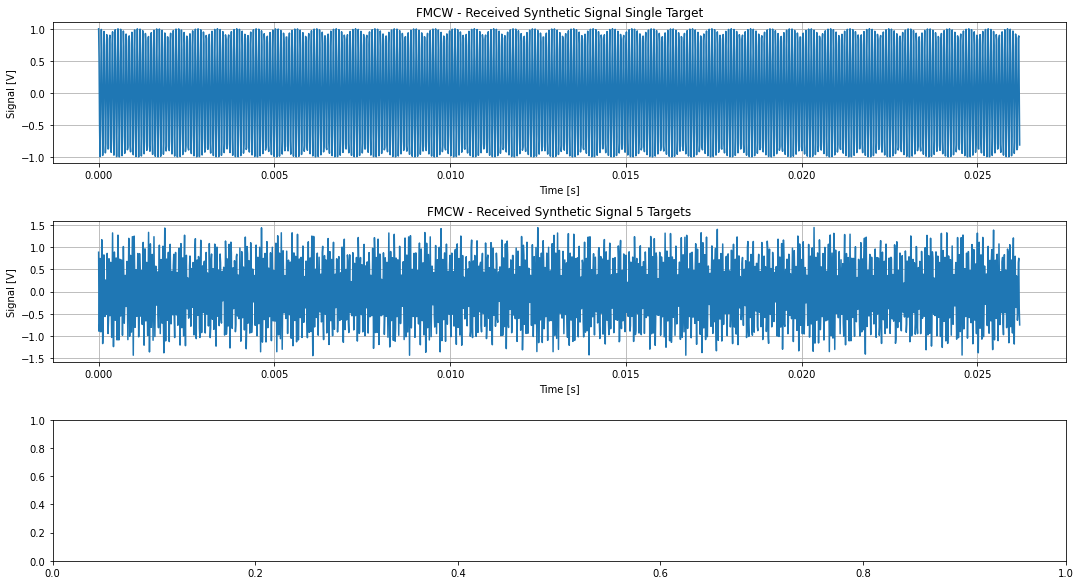

In [68]:
# synthetic signals:
plt.figure(figsize=(15, 8))
plt.subplot(311)
plt.plot(t, v_single)
plt.title('FMCW - Received Synthetic Signal Single Target')
plt.xlabel('Time [s]')
plt.ylabel('Signal [V]')
plt.grid()

plt.subplot(312)
plt.plot(t, v_sim)
plt.title("FMCW - Received Synthetic Signal %d Targets" % (len(R)))
plt.xlabel('Time [s]')
plt.ylabel('Signal [V]')
plt.tight_layout()
plt.grid()

# real signal:
plt.subplot(313)
plt.plot(t, v_actual)
plt.title("FMCW - Received Real Signal")
plt.xlabel('Time [s]')
plt.ylabel('Signal [V]')
plt.tight_layout()
plt.grid()

plt.show()

## 4. Frequency Analysis of Received Signals

### 4.1 Determination of Range Bin   
Note: Each DFT component is known as a range bin. Therefore: targets will only be distinguishable if they are separated by more than two range bins.

In [ ]:
# Take FFTs of our signals.  Note the convention to name FFTs with a
# capital letter.
V_single = np.fft.fft(v_single)
V_sim = np.fft.fft(v_sim)
V_actual = np.fft.fft(v_actual)

N = len(V_single)

# plot:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(14, 9))
fig.suptitle('FMCW - Received Synthetic Real Signals - Frequency Domain', fontsize=12)

with plt.style.context('thinner.mplstyle'):
    axes[0].plot(np.abs(V_single[:N // 2]))
    axes[0].set_ylabel("$|V_\mathrm{single}|$")
    axes[0].set_xlim(0, N // 2)
    axes[0].set_ylim(0, 1100)

    axes[1].plot(np.abs(V_sim[:N // 2]))
    axes[1].set_ylabel("$|V_\mathrm{sim} |$")
    axes[1].set_ylim(0, 1000)

    axes[2].plot(np.abs(V_actual[:N // 2]))
    axes[2].set_ylim(0, 750)
    axes[2].set_ylabel("$|V_\mathrm{actual}|$")

    axes[2].set_xlabel("FFT component $n$")

    for ax in axes:
        ax.grid()

plt.show()



### Logarithmic Plots: 

In [ ]:
def dB(y):
    "Calculate the log ratio of y / max(y) in decibel."

    y = np.abs(y)
    y /= y.max()

    return 20 * np.log10(y)


def log_plot_normalized(x, y, ylabel, ax):
    ax.plot(x, dB(y))
    ax.set_ylabel(ylabel)
    ax.grid()


rng = np.arange(N // 2) * spc.c / 2 / b_eff
V_single = np.fft.fft(v_single)
V_sim = np.fft.fft(v_sim)
V_actual = np.fft.fft(v_actual)
# plot:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(12, 8))
fig.suptitle('FMCW - Received Synthetic Real Signals - Frequency Domain Logarithmic Scale', fontsize=12)

with plt.style.context('thinner.mplstyle'):
    log_plot_normalized(rng, V_single[:N // 2], "$|V_{\mathrm{single}}|$ [dB]", ax0)
    log_plot_normalized(rng, V_sim[:N // 2], "$|V_{\mathrm{multi}}|$ [dB]", ax1)
    log_plot_normalized(rng, V_actual[:N // 2], "$|V_{\mathrm{actual}}|$ [dB]", ax2)

ax0.set_xlim(0, 300)  # Change x limits for these plots so that
ax1.set_xlim(0, 300)  # we are better able to see the shape of the peaks.
ax2.set_xlim(0, len(V_actual) // 2)
ax2.set_xlabel('range [m]')


# window time signals in order to minimize leakage effect
t_ms = t * 1000  # Sample times in milli-second
w = np.kaiser(N, 6.1)  # Kaiser window with beta = 6.1

V_single_win = np.fft.fft(w * v_single)
V_sim_win = np.fft.fft(w * v_sim)
V_actual_win = np.fft.fft(w * v_actual)

# plot:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(12, 8))
fig.suptitle('FMCW - Received Synthetic Real Signals - Frequency Domain Logarithmic Scale - Windowed', fontsize=12)

with plt.style.context('thinner.mplstyle'):
    log_plot_normalized(rng, V_single_win[:N // 2], "$|V_{\mathrm{single}}|$ [dB]", ax0)
    log_plot_normalized(rng, V_sim_win[:N // 2], "$|V_{\mathrm{multi}}|$ [dB]", ax1)
    log_plot_normalized(rng, V_actual_win[:N // 2], "$|V_{\mathrm{actual}}|$ [dB]", ax2)

ax0.set_xlim(0, 300)  # Change x limits for these plots so that
ax1.set_xlim(0, 300)  # we are better able to see the shape of the peaks.
ax2.set_xlim(0, len(V_actual) // 2)
ax2.set_xlabel('range [m]')

ax1.annotate("New, previously unseen!", (160, -35), xytext=(10, 15),
             textcoords="offset points", color='red', size='x-small',
             arrowprops=dict(width=0.5, headwidth=3, headlength=4,
                             fc='k', shrink=0.1));

plt.show()

## Further Exercises:
1. analyse range resolution by changing distance between targets; optimize system parameters in order to improve range resolution => chosen parameter set? ...
2. analyse effects of different windowing functions (Hanning, Blackman, Kaiser); create ranking (best ... worst);

## Determine Target Measured Distances (Find Peaks) 

In [ ]:
from scipy.signal import find_peaks

# find peaks:
x, peaks = find_peaks(np.abs(V_sim_win[:int(N/2)]), height=30)

#
print('Given Target Distances: ' + str(R) + ' [m]')
print('Measured Target Distances: ' + str(x*spc.c / 2 / b_eff) + ' [m]')

## Further Exercises:
1. modify parameters of system and find_peaks() function in order to detect all defined targets in array $R$